In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
#from shapely.ops import unary_union
import pandas 
import geopandas
import time

thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)


scale = 1
map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color_cycle = color_cycle + color_cycle
color_cycle = color_cycle + color_cycle

debug = 1
g = 0

print('ok')

ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.2 seconds.


## Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 137.1 seconds!


GEOID,15000US260992550004
STATEFP,26
COUNTYFP,99
TRACTCE,2550
BLKGRPCE,4
NAMELSAD,Block Group 4
MTFCC,G5030
FUNCSTAT,S
ALAND,521285
AWATER,0
INTPTLAT,+42.5363180


# Get state and county names for convenience

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
#tract_gdf = tract_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 17.2 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 4 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

# Geo-match block groups to the congressional districts they are in

## Create a new dataframe to hold block groups + matching districts

In [6]:
s = time.time()

assembler_gdf = pandas.DataFrame(data=None, columns=bg_gdf.columns)

print('Assigning variables to hold information about matches...')
assembler_gdf = assembler_gdf.assign(congressional_districts_bitmask_numeral = np.nan)
assembler_gdf = assembler_gdf.assign(congressional_districts_bitmask = np.nan)
assembler_gdf = assembler_gdf.assign(nDistricts = np.nan)

print('Assigning variable to hold matching district...')
assembler_gdf = assembler_gdf.assign(block_based_district = np.nan)

e = time.time()
g = g + (e-s)

print('Done in {0:,.0f} seconds!'.format(e-s))
print('GRAND TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


Assigning variables to hold information about matches...
Assigning variable to hold matching district...
Done in 0 seconds!
GRAND TOTAL TIME: 2 minutes 40 seconds!


## States with only one district

These are easy, everyone is in District 1.

In [7]:
s = time.time()
single_district_states = ['AK', 'DE', 'MT', 'ND', 'SD', 'VT', 'WY']

print('creating new dataframe to hold matches...')
assembler_gdf = pandas.DataFrame()

print('setting all block groups to District 1 for all single-district states...')

assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'].isin(single_district_states)]
assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = 1)
assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 'x1')
assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 1)
assembler_i_gdf = assembler_i_gdf.assign(block_based_district = 1)

assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=False)

print('backing up...')
bg_gdf_bk = bg_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)

print('Assigned districts for {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(assembler_gdf), e-s))


creating new dataframe to hold matches...
setting all block groups to District 1 for all single-district states...
backing up...
Assigned districts for 4,108 block groups in 0.2 seconds!


## States with 2 or more districts

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

### Create function to mark block groups with the districts they overlap

In [8]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')


defined district-marking function!


## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [9]:
s = time.time()

print('getting from backup...')
bg_gdf = bg_gdf_bk
assembler_gdf = assembler_gdf_bk

e = time.time()
g = g + (e-s)

for this_state in ['HI', 'ID', 'ME', 'NH', 'RI']:
    s = time.time()
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)
    
    
    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        
    
    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')
        
    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))
    
    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1
    
    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=False)
    if (debug > 0):
        print("\n")
    e = time.time()
    g = g + (e-s)

    print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))
    
print('GRAND TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
# print(assembler_gdf.groupby(['STUSAB', 'CD116']).size())
# assembler_gdf.sample(2).T

assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()


getting from backup...


Processing Hawaii...
	Assigning bitmask values to block groups in Hawaii...
		processing row 1 of 875...
		processing row 101 of 875...
		processing row 201 of 875...
		processing row 301 of 875...
		processing row 401 of 875...
		processing row 501 of 875...
		processing row 601 of 875...
		processing row 701 of 875...
		processing row 801 of 875...
		processing row 875 of 875...
	converting bitmask values to human-readable bitmasks...
	counting number of districts each block group overlaps...
	assigning congressional district to each block group with only one overlap...
	...-1 otherwise...
	joining Hawaii to the rest of the assembler dataframe...


matched districts for 875 block groups in HI in 0 minutes 28 seconds!


Processing Idaho...
	Assigning bitmask values to block groups in Idaho...
		processing row 1 of 963...
		processing row 101 of 963...
		processing row 201 of 963...
		processing row 301 of 963...
		processing row 401 of 963...
		processing row 

congressional_districts_bitmask
x01    393
x10    409
x11     13
dtype: int64

## Assign districts to block groups that overlap multiple districts

See examination sections below

In [10]:
print('Assigning districts based on examination to block groups that overlap multiple districts...')

# HAWAII
####  block groups with zero population are all water, belong to district 2 (outlying)
assembler_gdf.loc[['15000US150039900010','15000US150039807001'], 'block_based_district'] = 2
####  assigned these values by examination
assembler_gdf.loc['15000US150030001102', 'block_based_district'] = 1 # Honolulu County tract 1.10, BG 2
assembler_gdf.loc['15000US150030089241', 'block_based_district'] = 2 # Honolulu County tract 89.24, BG 1

# IDAHO
assembler_gdf.loc['15000US160010105031', 'block_based_district'] = 2 # Ada County tract 105.03 bg 1 
# ADA COUNTY tract 21.00 BG 1; 24.12 BG 1; 102.25 BG 1; 22.23 BG 1; 22.24 BG 1,3
assembler_gdf.loc[['15000US160010105031', '15000US160010021001','15000US160010024121','15000US160010102251','15000US160010022231','15000US160010022241','15000US160010022243'], 
                  'block_based_district'] = 1
# Fix to keep districts contiguous and aligned with actual districts
assembler_gdf.loc['15000US160010105031', 'block_based_district'] = 2


# RHODE ISLAND
assembler_gdf.loc['15000US440070001024', 'block_based_district'] = 2
assembler_gdf.loc[['15000US440070001022','15000US440070014005','15000US440070012002','15000US440070013002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US440070031004', '15000US440070031005', '15000US440070004001', '15000US440070006002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US440070008001', '15000US440070008002', '15000US440070008003', '15000US440070006001'], 'block_based_district'] = 2


print("backing up again...")
assembler_gdf_bk2 = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

print(assembler_gdf.groupby('nDistricts').size())
print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())


Assigning districts based on examination to block groups that overlap multiple districts...
backing up again...
nDistricts
1    8745
2      24
dtype: int64
STUSAB  block_based_district
AK      1.0                     534
DE      1.0                     574
HI      1.0                     422
        2.0                     453
ID      1.0                     434
        2.0                     529
ME      1.0                     522
        2.0                     564
MT      1.0                     842
ND      1.0                     572
NH      1.0                     454
        2.0                     468
RI      1.0                     417
        2.0                     398
SD      1.0                     654
VT      1.0                     522
WY      1.0                     410
dtype: int64


In [11]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_2.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 8,769 block groups in 0 minutes 0 seconds!
GRAND TOTAL TIME: 20  minutes 47 seconds!


In [12]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_2.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')

e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 151.8 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 6.3 seconds


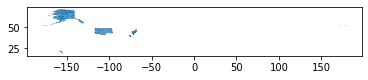

In [14]:
fig, ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.show()

## Examine overlapping districts

### RHODE ISLAND

#### Get water areas

In [ ]:
# s = time.time()

# this_state = 'RI'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 44

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))


#### Read places

In [ ]:
# s = time.time()

# this_state = 'RI'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 44

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(water_gdf), e-s))
# #place_gdf.head(1)

#### Overview

In [ ]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# this_state = 'RI'
# fig, ax = plt.subplots(1,1,figsize=(12*scale,8*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] == 1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] > 1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# #water_gdf.plot(ax=ax, color='blue')
# plt.show()


#### Examining

In [ ]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# print('calculating block group areas...')
# equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
# assembler_gdf = assembler_gdf.assign(area_km2 = assembler_gdf.to_crs(equal_area_crs).geometry.area/1000000)

# this_state = 'RI'
# fig, ax = plt.subplots(1,1,figsize=(24*scale,16*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['nDistricts'] == 1)
#     & (assembler_gdf['COUNTY_NAME'] == 'Providence County')
# ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] > 1)].plot(ax=ax, color='none', edgecolor='black', linewidth=4)

# # # # add labels for those block groups
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
# #    & (assembler_gdf['total_population'] > 0)
# ].iterrows():
#     annotator = ix[-4:]
# #     annotator += '\n'
#     #annotator = thisrow['Geography Name'].replace(',',"\n")
#     #annotator = thisrow['block_based_district']

#     plt.annotate(annotator, 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=12*scale, ha='center'
#                 )

# # print('plotting places...')

# place_gdf[place_gdf['NAME'] == 'Providence'].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'] == 'Boise City'].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  color='purple', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# print('plotting water...')
# water_gdf.plot(ax=ax, color='blue')


# # # Providence City
# # plt.xlim([-71.48, -71.38])
# # plt.ylim([41.77, 41.86])

# # Providence City
# plt.xlim([-71.43, -71.39])
# plt.ylim([41.8, 41.85])


# plt.show()

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'area_km2', 'total_population']
# ].sort_values('area_km2', ascending=False)



### HAWAII

In [ ]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# this_state = 'HI'
# fig, ax = plt.subplots(1,1,figsize=(12*scale,8*scale))

# # show districts
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')

# # show all block groups that overlap multiple districts
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['nDistricts'] > 1) 
#     & (assembler_gdf['total_population'] > 0)
# ].plot(ax=ax, color='none', edgecolor='black')

# # add labels for those block groups
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['nDistricts'] > 1) 
#     & (assembler_gdf['total_population'] > 0)
# ].iterrows():
#     annotator = ix
#     annotator += '\n'
#     annotator += thisrow['Geography Name'].replace(',',"\n")
#     #annotator = thisrow['block_based_district']

#     plt.annotate(annotator, 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y - .14), 
#                  color='black', backgroundcolor='white', fontsize=12*scale, ha='center'
#                 )
# # All of Oahu
# # plt.xlim([-158.5,-157.5])
# # plt.ylim([21.2,21.9])
# # Overlapping districts 
# plt.xlim([-158.2,-157.6])
# plt.ylim([21.25,21.5])

# plt.show()

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == 'HI') 
# #     & (assembler_gdf['nDistricts'] > 1)
# #     #& (assembler_gdf['total_population'] == 0)
# # ]


### IDAHO

#### Read water areas

In [ ]:
# s = time.time()

# this_state = 'ID'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 16

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))


#### Read places

In [ ]:
# s = time.time()

# this_state = 'ID'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 16

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(water_gdf), e-s))
# #place_gdf.head(1)

#### Overview

In [ ]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# this_state = 'ID'
# fig, ax = plt.subplots(1,1,figsize=(12*scale,8*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] == 1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] > 1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# water_gdf.plot(ax=ax, color='blue')
# plt.show()


#### Block groups that overlap multiple districts

In [ ]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# print('calculating block group areas...')
# equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
# assembler_gdf = assembler_gdf.assign(area_km2 = assembler_gdf.to_crs(equal_area_crs).geometry.area/1000000)

# this_state = 'ID'
# fig, ax = plt.subplots(1,1,figsize=(24*scale,16*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     #& (assembler_gdf['nDistricts'] > 1)
#     & (assembler_gdf['COUNTY_NAME'] == 'Ada County')
# ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] > 1)].plot(ax=ax, color='none', edgecolor='black', linewidth=4)

# # # # add labels for those block groups
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['nDistricts'] > 1) 
# #    & (assembler_gdf['total_population'] > 0)
# ].iterrows():
#     annotator = ix[-4:]
# #     annotator += '\n'
#     #annotator = thisrow['Geography Name'].replace(',',"\n")
#     #annotator = thisrow['block_based_district']

#     plt.annotate(annotator, 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=12*scale, ha='center'
#                 )

# print('plotting places...')

# place_gdf[place_gdf['NAME'] == 'Boise City'].plot(ax=ax, color='none', edgecolor='purple', linewidth=2)

# # for ix, thisrow in place_gdf[place_gdf['NAME'] == 'Boise City'].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  color='purple', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# # # # Ada County
# # plt.xlim([-116.6, -115.9])
# # plt.ylim([43.05, 43.75])

# # Just the big one
# # plt.xlim([-116.2, -116.05])
# # plt.ylim([43.5, 43.6])

# #All except the big one
# plt.xlim([-116.35, -116.1])
# plt.ylim([43.52, 43.72])


# # closeup of all 7 overlapping districts
# # plt.xlim([-116.36, -115.94])
# # plt.ylim([43.1,43.75])

# plt.show()

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['nDistricts'] > 1)
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'area_km2', 'total_population']
# ].sort_values('area_km2', ascending=False)


